<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Стационарность" data-toc-modified-id="Стационарность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Стационарность</a></span></li><li><span><a href="#теста-Дикки-Фуллера" data-toc-modified-id="теста-Дикки-Фуллера-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>теста Дикки-Фуллера</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
!pip install optuna -U

     |████████████████████████████████| 308 kB 1.3 MB/s            
     |████████████████████████████████| 81 kB 5.4 MB/s             
     |████████████████████████████████| 146 kB 12.1 MB/s            
     |████████████████████████████████| 49 kB 5.2 MB/s             
     |████████████████████████████████| 112 kB 12.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=5623f183c962c04075418299b1fd17ff2401b724627fcb4b0bb3c916d68160e2
  Stored in directory: /home/jovyan/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# %pip install optuna
import optuna

In [3]:
# загрузим данные и сохраним датасет, сделаем первую калонку как индекс
df = pd.read_csv('/datasets/taxi.csv',index_col=0,parse_dates=[0])

In [4]:
# на всякий случай отсортируем по индексу
df.sort_index(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


в нашем распоряжении 26496 наблюдений с марта по август 2018го

In [6]:
# предсказание требуется на один час - сделаем ресемплирование 
data = df.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


array([[<AxesSubplot:title={'center':'num_orders'}>]], dtype=object)

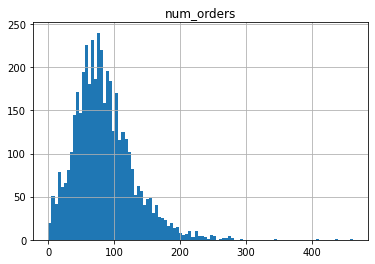

In [9]:
data.hist(bins=100)

В среднем 84 заказа в час, редко  бывает более 200 заказов за час. но необходимо изучить данные на тренды - скорее всего показатели меняются во времени

## Анализ

<AxesSubplot:>

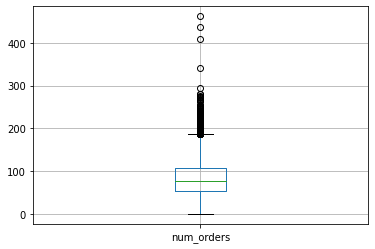

In [10]:
data.boxplot()

<AxesSubplot:xlabel='datetime'>

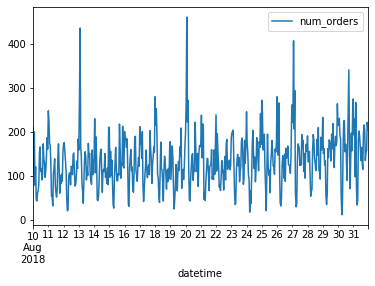

In [11]:
# посмотрим на график последней недели

data['2018-08-10':'2018-08-31'].plot()

In [12]:
data[data['num_orders'] > 350]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408


очевидно что в августе люди чаще посещают аэропорт так как сезон отпусков - и выходит что в ночь с воскресенья на понедельник людей с отпусков возвращается больше чем в другие дни

посмотрим на тренды циклы и сезонность с помощью seasonal_decompose

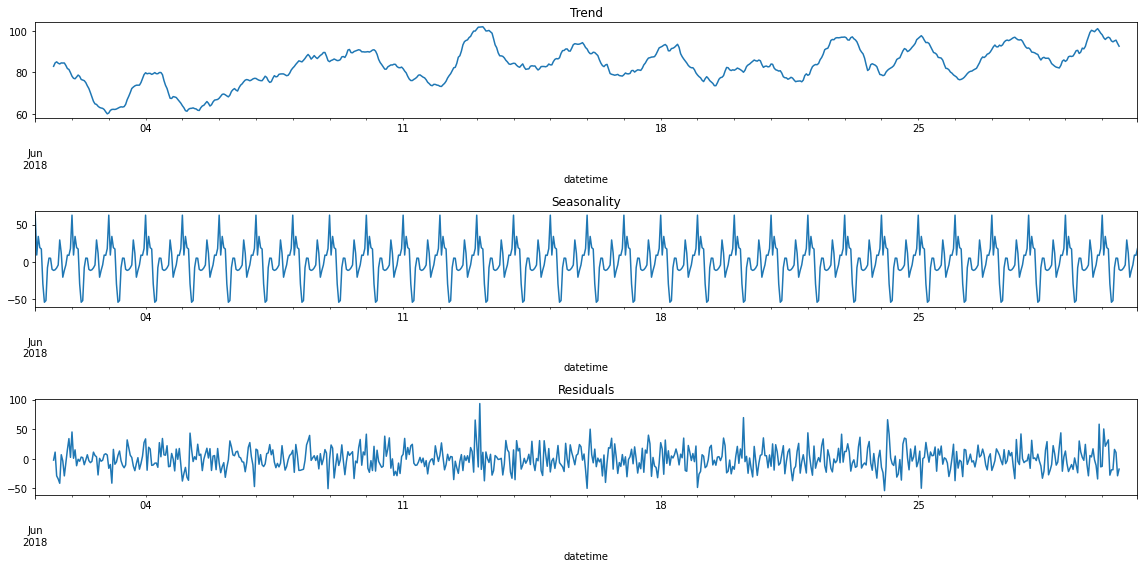

In [13]:
decomposed = seasonal_decompose(data['2018-06-1':'2018-06-30']) # < напишите код здесь >

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сделаем скользащую среднюю по дням неделям и месяцам

In [14]:
def plotMovingAverage(data, wind):
    plt.figure(figsize=(15,5))
    for n in wind:
        rolling_mean = data.rolling(window=n).mean()
        plt.plot(rolling_mean, label=f"Скользящая средняя\n за {n} ч")
    plt.title(f"Скользящая средняя") 
    plt.axis('tight')
    plt.legend(loc="upper left")
    plt.grid(True)

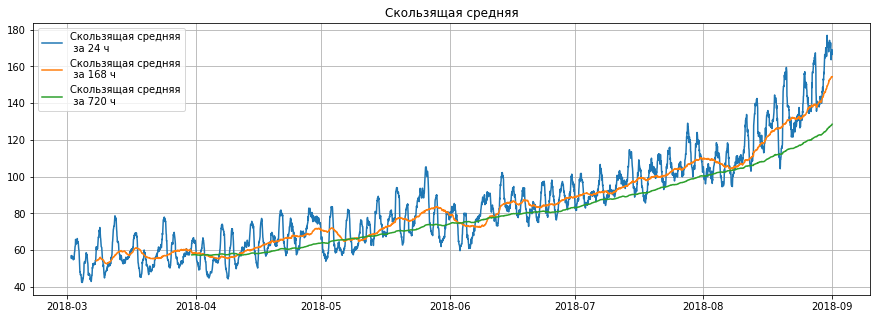

In [15]:
plotMovingAverage(data, [24,168,720])

Как видим из графика среднемесячное количество заказов растет в течении всего датасета. что является трендом. Цикличность была в видна внутри дня (день\ночь). Хотел увидеть какую нибудь цикличность на недельном графике расчитывая на стабильное изменение количества заказов на выходных днях - но этого нет. Есть не стабильные пики выподающие на понедельник среду и субботу

также заметно что в последний месяц прирост количества заказов идет с некоторым ускорением.

### Стационарность

Разобьём временной ряд на две последовательности. Затем рассчитаем среднее значение и дисперсию каждой группы чисел и сравним значения.

In [16]:
X = data['num_orders'].values
split = int(len(X) / 2)
X1, X2 = X[:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=65.003170, mean2=103.842391
variance1=1081.881783, variance2=2217.252333


разница в среднем и дисперсии очень большая - значит эти параметры меняются с течением времени - и речь может идти об отсутствии стационарности

### теста Дикки-Фуллера

проверим данные на стационарность с помощью теста Дикки-Фуллера

Нулевая гипотеза (H0): предполагает, что временной ряд нестационарный (имеет единичный корень). Он имеет некоторую временную структуру.

Альтернативная гипотеза (H1):  предполагает, что временной ряд является стационарным. Он не имеет временной структуры.

In [17]:
from statsmodels.tsa.stattools import adfuller

X = data['num_orders'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Значение p ниже порогового значения (5%) но выше порогового значения (1%)

При выполнении теста выводится статистическое значение -3. Чем более отрицательна эта статистика, тем больше вероятность того, что мы отвергнем нулевую гипотезу (у нас есть стационарный набор данных).

Получается что ряд более стационарный чем нет ...

Чтобы посмотреть на стационарный ряд, найдём разности его значений.

In [18]:
data_shift = data - data.shift(periods=1,fill_value=0)

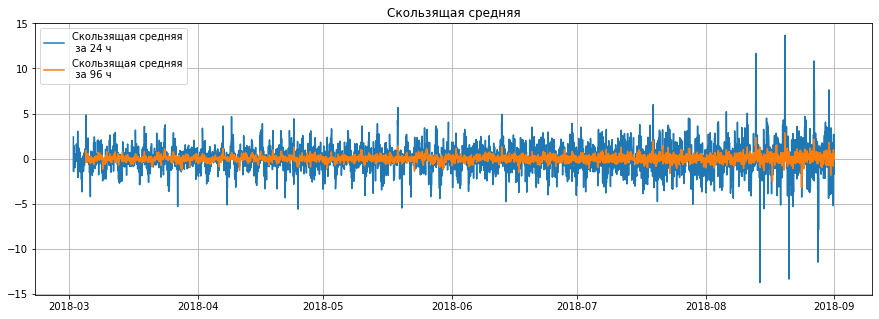

In [19]:
plotMovingAverage(data_shift, [24,96])

Разности временного ряда более стационарны, нелинейный тренд преобразовался в линейный

## Обучение

Создадим некоторые признаки для обучения модели, 

календарные признаки с днем недели и дём в месяце, а так же сделаем признаки по отстающим значениям.

In [20]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

In [21]:
# для создания признаков с отстающими значениями сделаем функцию

def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1,max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)  
    # для создания признака со скользящим средним с заданым окном и со сдвигом на одно наблюдение назад(чтоб не подглядывать)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [22]:
make_features(data, 24, 6)

In [23]:
data.head(10)

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.833333
2018-03-01 07:00:00,15,1,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.166667
2018-03-01 08:00:00,34,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000


Добавил признаки со скользящим средним за 6 часов и признаки с отстащищими значениями на каждый час в сутках

Теперь разделим на тренировочную и валидацонную выборки

In [24]:
data = data.dropna()
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [25]:
print(features_train.shape,  target_train.shape, features_test.shape, target_test.shape )

(3952, 27) (3952,) (440, 27) (440,)


## Тестирование

In [26]:
# функция для вывода графиков с предсказаниями

def show_y_pred(y, pred):
    plt.figure(figsize=(15,3))
    plt.plot(y,label='реальные данные')
    plt.plot(pred,label='предсказания')
    plt.legend(loc="upper left")
    plt.ylabel('Количкества заказов в час')
    plt.grid(True)

### Линейная регрессия

25.951966955270947


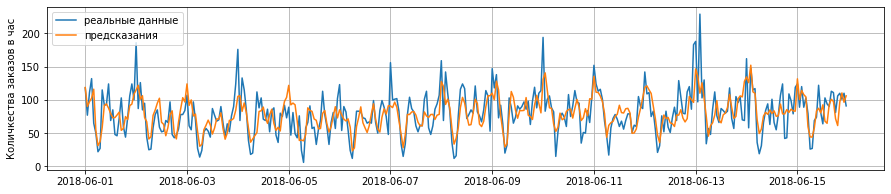

In [27]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

predicted = model_lr.predict(features_train)
df_pred = pd.DataFrame({'num_orders': target_train, 'pred': predicted})
show_y_pred(df_pred['num_orders']['2018-06-1':'2018-06-15'],df_pred['pred']['2018-06-1':'2018-06-15'])

print(mean_squared_error(target_train , predicted, squared=False))

45.022288261212125


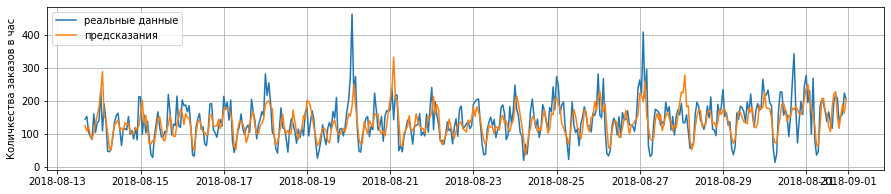

In [28]:
predicted = model_lr.predict(features_test)
df_pred = pd.DataFrame({'num_orders': target_test, 'pred': predicted})
show_y_pred(df_pred['num_orders'],df_pred['pred'])
print(mean_squared_error(target_test , predicted, squared=False))

как видно из графика - предсказания не дотягиваются до минимальных и максимальных пиков.

попробуем другие модели для улучшения метрики

### Гребневая регрессия

In [29]:
# исследуем временной ряд, то в каждом сплите тестовые индексы должны быть позже по времени, чем обучающие, 
# поэтому перетасовка обычным способом неуместна. Как раз TimeSeriesSplit решает эту проблему.
tscv = TimeSeriesSplit(n_splits=3)

In [30]:
# попробуем гребневую регрессию - 
# рекомендуют для наборов данных с большим количеством признаков, которые не являются независимыми друг от друга

model_rg = RidgeCV(alphas=[0.01],cv=tscv).fit(features_train, target_train)

predict_train = model_rg.predict(features_train)
predict_test = model_rg.predict(features_test)

print(f'RMSE на тренировочных данных: {mean_squared_error(target_train , predict_train, squared=False)}',
      f'\nRMSE на валидационных данных: {mean_squared_error(target_test , predict_test, squared=False)}')


RMSE на тренировочных данных: 25.95196695527095 
RMSE на валидационных данных: 45.02228826706076


### LightGBM

для поиска лучших гиперпараметов воспользуемся библиотекой optuna которая использует алгоритмы случайного перебора параметров

In [ ]:
def run(trial: optuna.Trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, 50),
        'max_depth': trial.suggest_int('max_depth', 10, 30, 5),
        'num_leaves': trial.suggest_int('num_leaves', 100, 300, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=None, log=True),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart', 'goss'])          
    }
    
    model_lgbm = LGBMRegressor(**params, objective='rmse', random_state=42)
    #model_lgbm.fit(features_train, target_train)
    
    score = cross_val_score(model_lgbm, features_train, target_train, n_jobs=-1, cv=tscv, scoring='neg_mean_squared_error')
    
    mean_score = score.mean() * (-1)
    #print(mean_score)
    return np.sqrt(mean_score)
    #score = np.sqrt(mean_squared_error(target_test, model_lgbm.predict(features_test)))
    #return score


start = datetime.now()

study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=15)

print(datetime.now() - start)

[I 2022-05-23 20:18:13,399] Trial 1 finished with value: 27.20282916351396 and parameters: {'n_estimators': 100, 'max_depth': 10, 'num_leaves': 300, 'learning_rate': 0.05536496087509466, 'boosting_type': 'goss'}. Best is trial 1 with value: 27.20282916351396.

In [ ]:
model_lgbm = LGBMRegressor(**study.best_params, random_state=0)
model_lgbm.fit(features_train, target_train)

print(np.sqrt(mean_squared_error(target_test, model_lgbm.predict(features_test))))
print(study.best_params)
print(study.best_value)

# model_lgbm = LGBMRegressor(objective='rmse', random_state=42)
# param = {
#     'n_estimators': [100,200,300],
#     'max_depth': [10,15,20],
#     'num_leaves': [100,200],
#     'learning_rate':[0.01 , 0.1, 0.2], 
#     'boosting_type':['gbdt','dart', 'goss']
#     }

# grid = GidSearchCV(model_lgbm, param, scoring = 'neg_mean_squared_error',  cv=tscv)
# grid.fit(features_train, target_train)

In [ ]:
# model_lgbm = LGBMRegressor(n_estimators=300,
#                            max_depth=15, 
#                            num_leaves=100, 
#                            learning_rate=0.2, 
#                            boosting_type='dart')
# model_lgbm.fit(features_train, target_train, categorical_feature='auto')


In [ ]:
predict = model_lgbm.predict(features_test)

# посмотрим как модель предскажет на тестовых данных
df_pred = pd.DataFrame({'num_orders': target_test, 'pred': predict})
show_y_pred(df_pred['num_orders'],df_pred['pred'])
print(mean_squared_error(target_test , predict, squared=False))


Но она не смогла предугатать пиковые значения в августовские понедельники. Видимо для этого необходимо добавить признак который бы отражал влияние данного фактора.

Линейные модели дали требуемое метрики и обучаются быстро - что позволит быстро делать прогнозы на следующий час.
Видим что модель с градиентным бустингом показала результат лучше, но процесс обучения занимает в разы больше времени.


Дополнительное направление для исследования может стать использование ARIMA модели - это модель, в которой временной ряд вычитался по крайней мере один раз, чтобы сделать его стационарным, и объединяются условия авторегрессии(AR) и скользящей средней(MA).